# Data Science

Debido al requerimiento del cliente, se procederan a reordenar la data, para obtener un set de datos horarios donde cada fila represente la cantidad de viajes realizados en esa hora en especifico(hora de comienzo del viaje).

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
df = pd.read_parquet('Data\process_taxis.parquet',engine='pyarrow')

In [42]:
df.set_index(keys='pickup_datetime',inplace=True)

In [43]:
df.index

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 00:00:05',
               '2023-01-01 00:00:06', '2023-01-01 00:00:08',
               '2023-01-01 00:00:09', '2023-01-01 00:00:18',
               '2023-01-01 00:00:47', '2023-01-01 00:00:52',
               '2023-01-01 00:01:07', '2023-01-01 00:01:08',
               ...
               '2024-06-30 23:59:49', '2024-06-30 23:59:49',
               '2024-06-30 23:59:51', '2024-06-30 23:59:51',
               '2024-06-30 23:59:54', '2024-06-30 23:59:54',
               '2024-06-30 23:59:55', '2024-06-30 23:59:56',
               '2024-07-01 00:00:27', '2024-07-01 00:05:23'],
              dtype='datetime64[us]', name='pickup_datetime', length=47089377, freq=None)

In [44]:
# Crear un nuevo DataFrame con la cantidad de registros por hora
df_hour = df.resample('H').size().to_frame('viajes')

In [45]:
df_hour.tail(2)

,viajes
pickup_datetime,
2024-06-30 23:00:00,1720
2024-07-01 00:00:00,2


In [46]:
df.columns

Index(['dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID',
       'DOLocationID', 'total_price', 'service', 'fuel_type',
       'energy_consumption', 'fuel_cost', 'trip_duration', 'labor', 'co2',
       'maintenance', 'net_profit'],
      dtype='object')

### <center>Models</center>

Para cumplir con las expectativas del cliente, se evaluaran 2 modelos

- Forecaster Autoregresive: 

Para modelar la evolución de los datos como serie de tiempo, se optó por un modelo Forecaster Autoregresivo que incorpora lags de la variable objetivo y variables de tiempo (como la hora, mes, dia, etc). Esta elección se fundamenta en la hipótesis de que los valores futuros de la serie están fuertemente influenciados por sus valores pasados y por patrones estacionales o cíclicos asociados a las variables de tiempo.

Los lags permiten capturar la autocorrelación presente en la serie, mientras que las variables de tiempo ayudan a modelar los componentes estacionales y de tendencia, lo que resulta en predicciones más precisas y robustas.
Luego de esto se evaluara el desempeño del modelo para su comparacion.

- Modelo de Predicción en Cascada(Autoregresion y Random Forest o regresion lineal multiple):

Para realizar predicciones futuras de la variable objetivo, el modelo se desarrollará en dos etapas. En la primera etapa, se utilizarán modelos predictivos para estimar los valores futuros de las variables auxiliares (ganancia neta, duración del viaje, y CO₂ emitido). Estas estimaciones serán generadas únicamente a partir de valores pasados de cada una de las variables auxiliares, aplicando un modelo autoregresivo puro. Así, para cada variable auxiliar, se entrenará un modelo autoregresivo independiente que capture las tendencias y patrones de su serie temporal individual sin depender de otras variables.

En la segunda etapa, las estimaciones futuras de estas variables auxiliares se utilizarán como entradas (features) en el modelo final. Este modelo tendrá como objetivo principal la predicción de la variable objetivo y empleará tanto los valores estimados de las variables auxiliares como el valor pasado de la variable objetivo para optimizar su precisión en las predicciones futuras. 

******

### <center>Target</center>

El desafio al cual nos ha sometido el cliente, es predecir la demanda de taxis, para lo cual es necesario saber o estimar un valor de cuantos viajes pudieran llegar a realizarse. Por lo cual, se utilizara como target la columna "viajes" creada a partir del recuento de instancias de nuestra data principal transformada en un dataframe con frecuencia horaria.



In [47]:
#sum_for_price = df['total_price'].resample('H').sum().to_frame('total_price')
#sum_for_cost = df['fuel_cost'].resample('H').sum().to_frame('fuel_cost')
sum_for_profit = df['net_profit'].resample('H').sum().to_frame('net_profit')
sum_for_duration = df['trip_duration'].resample('H').sum().to_frame('trip_duration')
sum_for_co2 = df['co2'].resample('H').sum().to_frame('co2')

In [48]:
# Unir los resultados en un solo DataFrame
df_hour = df_hour.join([sum_for_profit,sum_for_duration,sum_for_co2])

In [49]:
df_hour

,viajes,net_profit,trip_duration,co2
pickup_datetime,,,,
2023-01-01 00:00:00,4370,97207.925369,974.944444,24258.15776
2023-01-01 01:00:00,4543,102594.328054,989.394167,27604.39664
2023-01-01 02:00:00,3805,84971.601142,744.652500,24178.79168
2023-01-01 03:00:00,2853,63744.816193,533.422500,18230.76224
2023-01-01 04:00:00,1729,37629.893139,307.328333,11231.16080
...,...,...,...,...
2024-06-30 20:00:00,2889,59838.564601,609.137500,14353.05184
2024-06-30 21:00:00,2967,61374.740862,613.465278,15257.32128
2024-06-30 22:00:00,2495,50010.844181,485.215556,13230.58096


In [50]:
#df.reset_index(inplace=True)
#df['year'] = df['pickup_datetime'].dt.year
#df['quarter'] = df['pickup_datetime'].dt.quarter
#df['month'] = df['pickup_datetime'].dt.month
#df['day_month'] = df['pickup_datetime'].dt.day
#df['weekday'] = df['pickup_datetime'].dt.day_name()
#df['hour'] = df['pickup_datetime'].dt.hour
#df['weekend'] = df['pickup_datetime'].apply(lambda x: x.weekday() < 5).astype(int) # 1 = weekday, 0 = weekend
#df.drop(columns=['pickup_datetime','dropoff_datetime'],inplace=True)

In [51]:
df_hour.reset_index(inplace=True)

In [52]:
fecha = df_hour['pickup_datetime'][-1:].values[0]
ultima_fecha = pd.to_datetime(fecha)
print(fecha,"\n",ultima_fecha)

2024-07-01T00:00:00.000000 
 2024-07-01 00:00:00


In [53]:
df_hour[:10]

,pickup_datetime,viajes,net_profit,trip_duration,co2
0,2023-01-01 00:00:00,4370,97207.925369,974.944444,24258.15776
1,2023-01-01 01:00:00,4543,102594.328054,989.394167,27604.39664
2,2023-01-01 02:00:00,3805,84971.601142,744.652500,24178.79168
3,2023-01-01 03:00:00,2853,63744.816193,533.422500,18230.76224
4,2023-01-01 04:00:00,1729,37629.893139,307.328333,11231.16080
5,2023-01-01 05:00:00,628,12337.244940,97.538333,3223.26688
6,2023-01-01 06:00:00,468,8813.262989,72.400000,3029.20304
7,2023-01-01 07:00:00,573,10145.013892,79.927222,3004.18784
8,2023-01-01 08:00:00,676,12083.792491,101.755556,3657.96448
9,2023-01-01 09:00:00,1179,20707.888947,170.000000,6126.29696


In [54]:
num_dias = len(df_hour)
dates = pd.date_range(end=ultima_fecha, periods=num_dias,freq='60min')
dates

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2024-06-30 15:00:00', '2024-06-30 16:00:00',
               '2024-06-30 17:00:00', '2024-06-30 18:00:00',
               '2024-06-30 19:00:00', '2024-06-30 20:00:00',
               '2024-06-30 21:00:00', '2024-06-30 22:00:00',
               '2024-06-30 23:00:00', '2024-07-01 00:00:00'],
              dtype='datetime64[ns]', length=13129, freq='60T')

In [55]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from lightgbm import LGBMRegressor

In [56]:
lags=[1,30,90,180]
forecaster = ForecasterAutoreg(regressor=LGBMRegressor(random_state=42, verbose=-1), lags=lags)

In [57]:
forecaster.fit(y=df_hour['viajes'])

In [87]:
predictions = forecaster.predict(steps=48)

In [88]:
ultima_fecha = df_hour['pickup_datetime'].iloc[-1]
N = len(predictions)  # Número de predicciones futuras
fechas_futuras = pd.date_range(start=ultima_fecha, periods=N + 1, freq='H')[1:]  # Excluye la última fecha histórica


In [89]:
fechas_futuras

DatetimeIndex(['2024-07-01 01:00:00', '2024-07-01 02:00:00',
               '2024-07-01 03:00:00', '2024-07-01 04:00:00',
               '2024-07-01 05:00:00', '2024-07-01 06:00:00',
               '2024-07-01 07:00:00', '2024-07-01 08:00:00',
               '2024-07-01 09:00:00', '2024-07-01 10:00:00',
               '2024-07-01 11:00:00', '2024-07-01 12:00:00',
               '2024-07-01 13:00:00', '2024-07-01 14:00:00',
               '2024-07-01 15:00:00', '2024-07-01 16:00:00',
               '2024-07-01 17:00:00', '2024-07-01 18:00:00',
               '2024-07-01 19:00:00', '2024-07-01 20:00:00',
               '2024-07-01 21:00:00', '2024-07-01 22:00:00',
               '2024-07-01 23:00:00', '2024-07-02 00:00:00',
               '2024-07-02 01:00:00', '2024-07-02 02:00:00',
               '2024-07-02 03:00:00', '2024-07-02 04:00:00',
               '2024-07-02 05:00:00', '2024-07-02 06:00:00',
               '2024-07-02 07:00:00', '2024-07-02 08:00:00',
               '2024-07-

In [ ]:
predictions = pd.DataFrame(predictions)
#predictions

,0
0,174.659428
1,218.280957
2,292.965420
3,264.084285
4,243.656667
5,322.479582
6,791.184540
7,1359.183263
8,2655.269812
9,3279.279650


In [91]:
# Asignamos estas fechas a tu dataframe de predicciones
predictions['fecha'] = fechas_futuras

In [93]:
#predictions.rename(columns={'0':'viajes'})
predictions.columns = ['viajes','fecha']

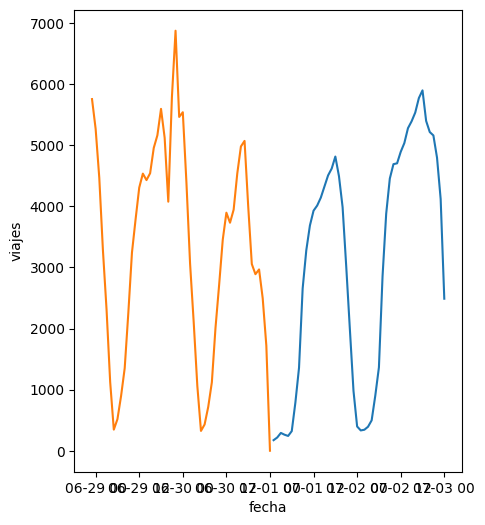

In [94]:
fig = plt.figure(figsize=(5,6))
axes = plt.axes()
sns.lineplot(data=predictions,ax=axes,x=predictions['fecha'],y='viajes')
sns.lineplot(data=df_hour,ax=axes,x=df_hour['pickup_datetime'][-50:],y='viajes')
plt.show()